In [353]:
import itertools
from functools import partial
from math import erf as erf_, exp as exp_, sin
from typing import Optional

import math
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer

import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import numpy.typing as npt
import numba.types as nbt
import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from numpy import pi, sqrt
from sklearn.model_selection import train_test_split
from torch.nn.parameter import Parameter
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

In [9]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/analytic-gen-burgers-fisher/gen-burgers-fisher-t5-small-out.csv
/kaggle/input/analytic-gen-burgers-fisher/gen-burgers-fisher-t0-small-out.csv
/kaggle/input/analytic-gen-burgers-fisher/gen-burgers-fisher-t0.1-small-out.csv


In [307]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()

        """1D Fourier layer: FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels

        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes = modes

        self.scale = 1. / (in_channels*out_channels)
        self.weights = nn.Parameter(self.scale
                                    * torch.rand(
                                        self.in_channels,
                                        self.out_channels,
                                        self.modes,
                                        dtype=torch.cdouble))

        # self.einsum_path_ = None

    def batch_complex_mult(self, input, weights):
        """Multiply the complex weights and input using the following
            tensorial contraction along the in_channel:
            (batch, in_channel, x_i) * (in_channel, out_channel, x_w)
                -> (batch, out_channel, x)

            Note that the x dim is kept, so there is no summation
            going on along it.


            In other words, perform a linear transform
            in the complex plane.
        """

        # if self.einsum_path_ is None:
        #     path = np.einsum_path(
        #         'bix,iox->box',
        #         input,
        #         weights,
        #         optimize='optimal')[0]

        # return np.einsum(
        #     'bix,iox->box',
        #     input,
        #     weights,
        #     optimize=self.einsum_path_)

        return torch.einsum(
            'bix,iox->box',
            input,
            weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coeff's up to a factor of modulus 1 (phase info)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1)//2 + 1,
            device=x.device,
            dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.batch_complex_mult(
            x_ft[:, :, :self.modes],
            self.weights)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))

        return x

In [360]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desired channel dimension
            by self.fc0_dim_lift.
        2. 4 layers of integral operators u' = (W + K)(u) with
            W defined by self.bias_w{k}; K defined by self.conv{k}.
        3. Project from the channel space to some lower dimensional space
            by self.fc1_dim_lower, apply a non-linear activation function,
            and project back to the output space by self.fc2.

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        self.padding = 2  # pad the domain if input is non-periodic
        self.fc0_dim_lift = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv4 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv5 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv6 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv7 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv8 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv9 = SpectralConv1d(self.width, self.width, self.modes)
        self.bias_w0 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w1 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w2 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w3 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w4 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w5 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w6 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w7 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w8 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w9 = nn.Conv1d(self.width, self.width, 1)
        

        self.fc1_dim_lower = nn.Linear(self.width, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0_dim_lift(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.bias_w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.bias_w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.bias_w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.bias_w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv4(x)
        x2 = self.bias_w4(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv5(x)
        x2 = self.bias_w5(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv6(x)
        x2 = self.bias_w6(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv7(x)
        x2 = self.bias_w7(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv8(x)
        x2 = self.bias_w8(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv9(x)
        x2 = self.bias_w9(x)
        x = x1 + x2


        x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1_dim_lower(x)
        x = F.gelu(x)
        x = self.fc2(x)

        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(
            np.linspace(0, 1, size_x),
            dtype=torch.float64)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])

        return gridx.to(device)

In [401]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [424]:
def train_model(epochs, loss, optimizer, scheduler):
    for epoch in tqdm(range(epochs)):
        model.train()
        t1 = timeit.default_timer()
        train_l2 = 0

        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)

            l2 = loss(out.view(batch_size, -1),
                      y.view(batch_size, -1))

            l2.backward()
            optimizer.step()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += loss(out.view(batch_size, -1),
                                y.view(batch_size, -1)).item()

        train_l2 /= u_train.shape[0]
        test_l2 /= u_test.shape[0]

        t2 = timeit.default_timer()
        print(epoch, t2-t1, train_l2, test_l2)

In [403]:
full_a = np.loadtxt('/kaggle/input/analytic-gen-burgers-fisher/gen-burgers-fisher-t0-small-out.csv', delimiter=',')
full_u = np.loadtxt('/kaggle/input/analytic-gen-burgers-fisher/gen-burgers-fisher-t5-small-out.csv', delimiter=',')

In [405]:
cut_a = full_a[::4, ::10]
cut_u = full_u[::4, ::10]

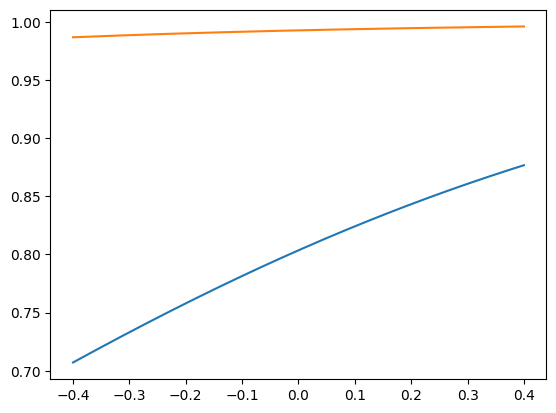

In [406]:
plt.plot(np.linspace(-0.4, 0.4, 10001)[::10], cut_a[100])
plt.plot(np.linspace(-0.4, 0.4, 10001)[::10], cut_u[100])

In [407]:
a_train, a_test, u_train, u_test = train_test_split(torch.from_numpy(cut_a),
                                                    torch.from_numpy(cut_u),
                                                    test_size=0.2,
                                                    random_state=42)

In [408]:
batch_size = 20

a_train = a_train.reshape(*a_train.shape, 1)
a_test = a_test.reshape(*a_test.shape, 1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_train, u_train),
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_test, u_test),
                                          batch_size=batch_size, shuffle=False)

In [409]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f'{name}: {params}')
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params

modes = 16
width = 64

model = FNO1d(modes, width).double().cuda()

print(count_parameters(model))

fc0_dim_lift.weight: 128
fc0_dim_lift.bias: 64
conv0.weights: 65536
conv1.weights: 65536
conv2.weights: 65536
conv3.weights: 65536
conv4.weights: 65536
conv5.weights: 65536
conv6.weights: 65536
conv7.weights: 65536
conv8.weights: 65536
conv9.weights: 65536
bias_w0.weight: 4096
bias_w0.bias: 64
bias_w1.weight: 4096
bias_w1.bias: 64
bias_w2.weight: 4096
bias_w2.bias: 64
bias_w3.weight: 4096
bias_w3.bias: 64
bias_w4.weight: 4096
bias_w4.bias: 64
bias_w5.weight: 4096
bias_w5.bias: 64
bias_w6.weight: 4096
bias_w6.bias: 64
bias_w7.weight: 4096
bias_w7.bias: 64
bias_w8.weight: 4096
bias_w8.bias: 64
bias_w9.weight: 4096
bias_w9.bias: 64
fc1_dim_lower.weight: 65536
fc1_dim_lower.bias: 1024
fc2.weight: 1024
fc2.bias: 1
Total Trainable Params: 764737
764737


In [411]:
learning_rate = 0.001
step_size = 50
gamma = 0.5
optimizer = Adam(model.parameters(),
                 lr=learning_rate,
                 weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=step_size,
                                            gamma=gamma)

loss = LpLoss(size_average=False)

In [412]:
torch.cuda.is_available()

True

In [425]:
train_model(100, loss, optimizer, scheduler)

  1%|          | 1/100 [00:02<04:41,  2.84s/it]

0 2.842143583999132 0.0015177928832954327 0.001568689768581285


  2%|▏         | 2/100 [00:05<04:38,  2.84s/it]

1 2.832196583000041 0.0020756409882687708 0.0019195252187034558


  3%|▎         | 3/100 [00:08<04:35,  2.84s/it]

2 2.8321027500023774 0.002122433786994537 0.0027429253373349623


  4%|▍         | 4/100 [00:11<04:32,  2.84s/it]

3 2.836105538000993 0.00179527710541082 0.001390574154723316


  5%|▌         | 5/100 [00:14<04:29,  2.84s/it]

4 2.83297345399842 0.002297795098381299 0.0033423703001360288


  6%|▌         | 6/100 [00:17<04:26,  2.84s/it]

5 2.8362934550023056 0.0017684152594450928 0.0017948336424203043


  7%|▋         | 7/100 [00:19<04:23,  2.84s/it]

6 2.8334602100003394 0.0015552842984654625 0.0015575487691219727


  8%|▊         | 8/100 [00:22<04:20,  2.84s/it]

7 2.8349921529988933 0.0015550614635176088 0.0013543973418304088


  9%|▉         | 9/100 [00:25<04:18,  2.84s/it]

8 2.842778764999821 0.0019946910552919982 0.0013420391800418217


 10%|█         | 10/100 [00:28<04:15,  2.84s/it]

9 2.8337039289981476 0.0015736711784200648 0.0013606434251455688


 10%|█         | 10/100 [00:30<04:31,  3.01s/it]


KeyboardInterrupt: 

In [340]:
save_path = './fno-1e-2 - 10layers.pth'
torch.save(model.state_dict(), save_path)

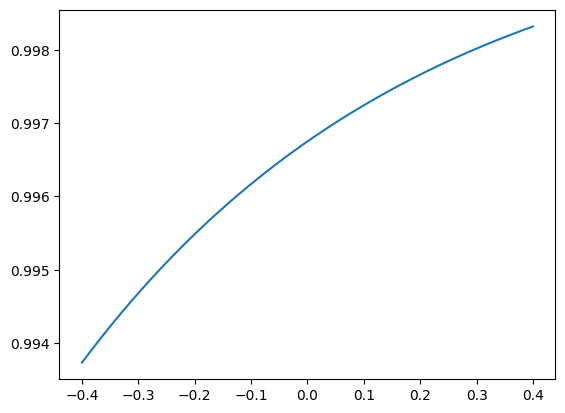

In [290]:
plt.plot(np.linspace(-0.4, 0.4, 10001), full_u[34])

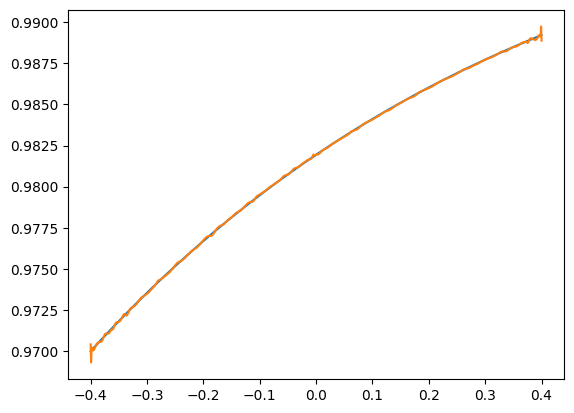

In [345]:
func_test = full_a[844:845, ::10]
func_test = torch.from_numpy(func_test)
func_test = func_test.reshape(*func_test.shape, 1)
func_test = func_test.cuda()
func_true = full_u[844, ::10]
model_res = model.forward(func_test)
model_res = model_res.detach().cpu().numpy()
plt.plot(np.linspace(-0.4, 0.4, 10001)[::10], func_true)
plt.plot(np.linspace(-0.4, 0.4, 10001)[::10], model_res[0])